<a href="https://colab.research.google.com/github/shriyashrestha2/BP-Fall-24/blob/main/Data_Science_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitch Recommendation System

Group Members: Ritwika Das, Nideesh Bharath Kumar, Shriya Shrestha

## Import Statements

In [ ]:
!pip install websocket-client requests pyngrok

In [ ]:
!pip install transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 894.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import json
import random
import time
import re
import threading
import requests
from pyngrok import conf, ngrok
import websocket
from datetime import datetime
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
import glob
from difflib import get_close_matches
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt

## Twitch API Integration

Client ID and Client Secret Keys to access Twitch API

In [ ]:
CLIENT_ID = 'gqvdji473lk1d7ka471jn9db93qjr9'
CLIENT_SECRET = 'd2365e4zr946878dxy3q49wp4r78vj'

Getting the Oauth Token from Twitch API to allow authorization.

In [ ]:
def get_twitch_token():
    url = 'https://id.twitch.tv/oauth2/token'
    params = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'grant_type': 'client_credentials'
    }
    res = requests.post(url, params=params)
    res.raise_for_status()
    return res.json()['access_token']

access_token = get_twitch_token()

HEADERS = {
    'Client-ID': CLIENT_ID,
    'Authorization': f'Bearer {access_token}'
}

Gets a list of the live streamers currently streaming on Twitch, and returns the list as a .json file with the streamer usernames.

In [ ]:
def get_live_streamers(limit):
    url = 'https://api.twitch.tv/helix/streams'
    params = {'first': limit}
    res = requests.get(url, headers=HEADERS, params=params)
    res.raise_for_status()
    data = res.json()['data']
    return [stream['user_name'].lower() for stream in data]

Cleans the messages received from Twitch, by removing any links, characters, and making all words lowercase to simplify training of the data.

In [ ]:
def clean_message(msg):
    msg = re.sub(r"http\S+", "", msg)
    msg = re.sub(r"[^A-Za-z0-9\s]+", "", msg)
    return msg.lower().strip()

Entire class that has all functions for getting a message, cleaning it, storing it into a json based on the streamer, and placing it all in a folder path.

In [ ]:
class TwitchChatCollector:
    def __init__(self, streamer):
        self.streamer = streamer
        self.messages = []
        self.ws = None

    def on_message(self, ws, message):
        if "PRIVMSG" in message:
            try:
                parts = message.split(":", 2)
                if len(parts) > 2:
                    raw_msg = parts[2]
                    cleaned = clean_message(raw_msg)
                    self.messages.append(cleaned)
                    print(f"[{self.streamer}] {cleaned}")
            except Exception as e:
                print(f"Error parsing message: {e}")

    # Opens the Twitch account to recieve the data from Twitch API
    def on_open(self, ws):
        ws.send("PASS oauth:tospw7iiv95sk1rqg5092rndixx70n")
        ws.send("NICK data_science_project")
        ws.send(f"JOIN #{self.streamer}")

    # If an error occurs while collecting streamer information
    def on_error(self, ws, error):
        print(f"[{self.streamer}] WebSocket error: {error}")

    # Closing the collecting data connection
    def on_close(self, ws, code, msg):
        print(f"[{self.streamer}] Closed connection")

    # Start recieving any chat data from Twitch API
    def start(self):
        self.ws = websocket.WebSocketApp(
            "wss://irc-ws.chat.twitch.tv:443",
            on_open=self.on_open,
            on_message=self.on_message,
            on_error=self.on_error,
            on_close=self.on_close
        )
        self.thread = threading.Thread(target=self.ws.run_forever)
        self.thread.start()


    # Stop recieving any chat data from Twitch API
    def stop(self):
        if self.ws:
            self.ws.close()
            self.thread.join()

    # Saving all the chat data recieved from each streamer into .json files and storing them in a folder path
    def save_messages(self, folder_path="twitch_chat_logs"):
        os.makedirs(folder_path, exist_ok=True)

        filename = f"{self.streamer}_chat_{datetime.now().strftime('%Y%m%d%H%M%S')}.json"
        filepath = os.path.join(folder_path, filename)

        with open(filepath, 'w') as f:
            json.dump(self.messages, f, indent=2)

        print(f"Saved {len(self.messages)} messages for {self.streamer} to {filepath}")


## Collection of Chat Data

Main function that prints out all the chat data it is receiving from Twitch API and then displaying the total amount of chats from each streamer after collecting for about 60 seconds.

In [ ]:
def main():
    folder_path = "twitch_chat_logs"
    streamers = get_live_streamers(limit=20)
    collectors = [TwitchChatCollector(s) for s in streamers]

    print(f"Starting chat collection for: {streamers}")

    for collector in collectors:
        collector.start()

    # Collect chat data for 60 seconds
    time.sleep(60)

    for collector in collectors:
        collector.stop()
        collector.save_messages(folder_path=folder_path)

if __name__ == "__main__":
    main()

Starting chat collection for: ['zackrawrr', 'hasanabi', 'eliasn97', 'stableronaldo', 'gotaga', 'trymacs', 'tanzverbot', 'alanzoka', 'blastdota', 'jynxzi', 'dkincc', 'otplol_', 'elxokas', 'sodapoppin', 't2x2', 'relog_pari_dota_ru', 'solluminati', 'noway4u_sir', 'call of duty']
[trymacs] xd
[t2x2] z s pfhebk tt ghb vfnthb
[solluminati] heeeeeeeeeeeeeeeeeee
[elxokas] noahh244 quien te esta faltando el respeto
[zackrawrr] om
[sodapoppin] toddw clap
[t2x2] 
[jynxzi] wwwwww
[solluminati] yea we good
[t2x2] 
[solluminati] seeyuh
[solluminati] y
[t2x2] 
[dkincc] kappa kappa kappa
[solluminati] heeeeeeeeeee
[t2x2] 
[eliasn97] die sure ist der wirt
[solluminati] hy
[solluminati] yea
[tanzverbot] lass los
[stableronaldo] so you guys saying rt because you guys are also chopped and shiut
[solluminati] yes
[jynxzi] amsterdam
[zackrawrr] lul
[jynxzi] viperuswokege viperuswokege viperuswokege viperuswokege
[stableronaldo] there are 7 million
[solluminati] sure
[tanzverbot] gta 6
[solluminati] fasho
[t

## Converting JSON to DataFrame

These are example user based input templates made for the model to determine what streamer would be a best fit for them.


In [ ]:
preference_templates = [
    "I'm looking for a calm and cozy community.",
    "I want an energetic and funny chat with lots of memes.",
    "I prefer strategic talk and respectful discussion.",
    "I like hype moments and esports energy.",
    "I'm into chill vibes and friendly interactions.",
    "I want chaotic and spammy but hilarious chat.",
    "Looking for streamer with a welcoming and kind chat.",
    "I want a toxic but entertaining and argumentative chat."
]

Creates training samples from the .json files of chat data we created right before this. Therefore we can train the model on this created dataset.

In [ ]:
# Selects a random message from the list of chats in the .json file
def sample_messages(messages, num=20):
    return "\n".join(random.sample(messages, min(num, len(messages))))

# Generates a dataset by going through each .json file in the folder path and seperating information based on prompts, chats and responses
def generate_dataset(chat_folder):
    dataset = []
    for file in os.listdir(chat_folder):
        if file.endswith(".json"):
            with open(os.path.join(chat_folder, file), 'r') as f:
                messages = json.load(f)
                streamer = file.replace(".json", "").split("_chat_")[0]
                for _ in range(5):
                    entry = {
                        "prompt": random.choice(preference_templates),
                        "chats": sample_messages(messages, num=20),
                        "response": streamer
                    }
                    dataset.append(entry)
    return dataset

dataset = generate_dataset("twitch_chat_logs")
with open("chat_recommendation_dataset.json", "w") as f:
    for item in dataset:
        f.write(json.dumps(item) + "\n")

print(f"Created {len(dataset)} training samples.")

Created 95 training samples.


Going through the dataset created and checking the information and display some of the data to verify it was done correctly

In [ ]:
with open("chat_recommendation_dataset.json", "r") as f:
    data = [json.loads(line) for line in f]


df = pd.DataFrame(data)

print(df.head())
print(df.describe(include='all'))
print(df['response'].value_counts())


                                              prompt  \
0  I prefer strategic talk and respectful discuss...   
1         I'm looking for a calm and cozy community.   
2  I prefer strategic talk and respectful discuss...   
3  I prefer strategic talk and respectful discuss...   
4  I want a toxic but entertaining and argumentat...   

                                               chats response  
0  \ndinodance dinodance dinodance dinodance dino...   dkincc  
1  \ndinodance dinodance dinodance dinodance\nmid...   dkincc  
2  bangboobounce bangboobounce bangboobounce bang...   dkincc  
3  \n\nmidlertanec midlertanec midlertanec midler...   dkincc  
4  \nmidlertysa midlertanec midlertysa midlertane...   dkincc  
                                            prompt chats response
count                                           95    95       95
unique                                           8    88       19
top     I'm looking for a calm and cozy community.         dkincc
freq           

## Model Creation and Training

Originally, we were using DistilGPT2 as our LLM model.

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
dataset = load_dataset('json', data_files='chat_recommendation_dataset.json', split='train')

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def format_for_lm(example):
    prompt = f"User: {example['prompt']}\nChat:\n{example['chats']}\nRecommend:"
    target = f" {example['response']}"
    example['text'] = prompt + target
    return example

dataset = dataset.map(format_for_lm)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize, batched=True)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./llm_chat_recommender",
    overwrite_output_dir=True,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-0382a0a255fc>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,5.184300
20,5.059800
30,4.373300
40,4.593900
50,4.125400
60,4.375000
70,4.006600
80,3.487000
90,3.543100
100,4.180800


TrainOutput(global_step=144, training_loss=4.034119937154982, metrics={'train_runtime': 1838.7447, 'train_samples_per_second': 0.155, 'train_steps_per_second': 0.078, 'total_flos': 37234786959360.0, 'train_loss': 4.034119937154982, 'epoch': 3.0})

Saves the training of the model, so that we do not have to keep training the model over and over.

In [ ]:
trainer.save_model("./llm_chat_recommender_final")
tokenizer.save_pretrained("./llm_chat_recommender_final")

from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("./llm_chat_recommender_final")
tokenizer = AutoTokenizer.from_pretrained("./llm_chat_recommender_final")

In [ ]:
def load_chat_log(file_path, max_lines=20):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return "\n".join([line.strip() for line in lines[-max_lines:]])

log_files = glob.glob("twitch_chat_logs/*.json")
latest_log = max(log_files, key=os.path.getctime)
chat_text = load_chat_log(latest_log)


## Testing

Generating a reccomendation based on the trained model.

In [ ]:
def generate_recommendation(user_input, chat_logs, model, tokenizer, valid_streamers):
    prompt = f"""User: {user_input}
Chat:\n{chat_logs}
Recommend:"""

    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate the output using the model
    output = model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.6,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode the output
    decoded = tokenizer.decode(output[0], skip_special_tokens=True).strip()


    # Remove the prompt part if the model repeats it
    predicted = decoded.split("Recommend:")[-1].strip() if "Recommend:" in decoded else decoded

    print("decoded" + str(decoded))

    # Debug print statements for raw output and predicted part
    print("RAW MODEL OUTPUT:", decoded)
    print("PREDICTED PART ONLY:", predicted)

    # First, try direct containment to match a streamer name
    for streamer in valid_streamers:
        if streamer.lower() in predicted.lower():
            return streamer

    # If no direct match, use fuzzy matching to find the closest streamer
    matches = get_close_matches(predicted.lower(), valid_streamers, n=1, cutoff=0.2)
    if matches:
        return matches[0]

    # If no match is found, return the "Unknown" message with the model's output
    return f"Unknown — model output: {predicted}"


In [ ]:
try:
    valid_streamers = get_live_streamers(limit=5)
    print("Valid streamers:", valid_streamers)
except requests.exceptions.RequestException as e:
    print(f"Error fetching live streamers: {e}")
    valid_streamers = []

user_input = "I want an energetic and funny chat with lots of memes."
streamer_key = generate_recommendation(user_input, chat_text, model, tokenizer, valid_streamers)

print("Recommended Streamer:", streamer_key)

Valid streamers: ['zackrawrr', 'hasanabi', 'stableronaldo', 'eliasn97', 'trymacs']
decodedUser: I want an energetic and funny chat with lots of memes.
Chat:
[]
Recommend: blastberrd
Recommend: blastberrd
RAW MODEL OUTPUT: User: I want an energetic and funny chat with lots of memes.
Chat:
[]
Recommend: blastberrd
Recommend: blastberrd
PREDICTED PART ONLY: blastberrd
Recommended Streamer: stableronaldo


## Updated Model

After observing that our previous model was not always outputting a valid streamer, we realized that using fuzzy matching was not an optimal way to train based off of this data. Therefore, we decided to switch to a different model all-MiniLM-L6-v2. This model allowed better classification and improved in detecting a proper streamer based on the user prompts.

In [ ]:
prompt = "I want an energetic and funny chat with lots of memes."
llm  = SentenceTransformer("all-MiniLM-L6-v2")

def tidy(chat: str) -> str:
    return re.sub(r"\s+", " ", chat.strip()).lower()

body = [prompt]
files  = []

for path in glob.glob("twitch_chat_logs/*.json"):
    with open(path, encoding="utf-8") as f:
        doc = " ".join(re.sub(r"\s+", " ", s.strip()).lower() for s in json.load(f) if isinstance(s, str))
    body.append(doc)
    files.append(os.path.basename(path))

chat_embed = llm.encode(body, convert_to_tensor=True)
scores = util.cos_sim(chat_embed[0], chat_embed[1:]).cpu().numpy().flatten()

rec = files[scores.argmax()]
print(f"Streamer Rec: {rec.split('_')[0]}")

print("\nTop 10 Rec:")
for i in (-scores).argsort()[:10]:
    print(f"{files[i]}  {scores[i]}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Streamer Rec: dkincc

Top 10 Rec:
dkincc_chat_20250507201306.json  0.22071853280067444
solluminati_chat_20250507201306.json  0.1894437074661255
t2x2_chat_20250507201306.json  0.18660497665405273
stableronaldo_chat_20250507201305.json  0.15892252326011658
zackrawrr_chat_20250507201305.json  0.14629216492176056
relog_pari_dota_ru_chat_20250507201306.json  0.13432025909423828
call of duty_chat_20250507201316.json  0.13246507942676544
sodapoppin_chat_20250507201306.json  0.12926292419433594
elxokas_chat_20250507201306.json  0.1229570284485817
gotaga_chat_20250507201306.json  0.10753345489501953


## Plots

This plot shows all the top similarity scores for streamers

Top 10 Recommendations:
dkincc: 0.2207
solluminati: 0.1894
t2x2: 0.1866
stableronaldo: 0.1589
zackrawrr: 0.1463
relog: 0.1343
call of duty: 0.1325
sodapoppin: 0.1293
elxokas: 0.1230
gotaga: 0.1075


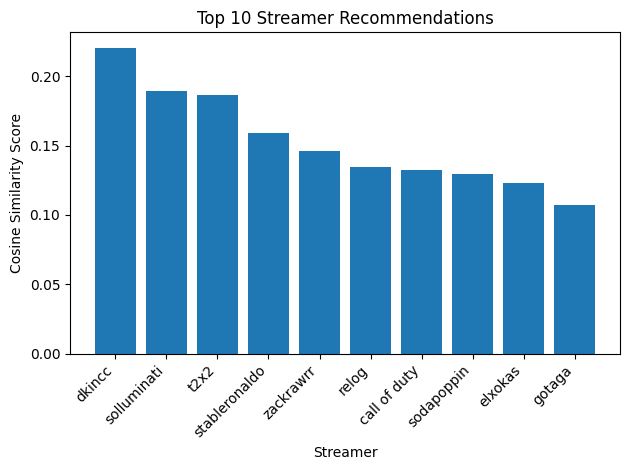

In [ ]:
top_idx = np.argsort(-scores)[:10]
top_files = [files[i].split('_')[0] for i in top_idx]
top_scores = scores[top_idx]

print("Top 10 Recommendations:")
for name, sc in zip(top_files, top_scores):
    print(f"{name}: {sc:.4f}")

plt.figure()
plt.bar(top_files, top_scores)
plt.xlabel("Streamer")
plt.ylabel("Cosine Similarity Score")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Streamer Recommendations")
plt.tight_layout()
plt.show()

This plot shows the spread of all the similarity scores

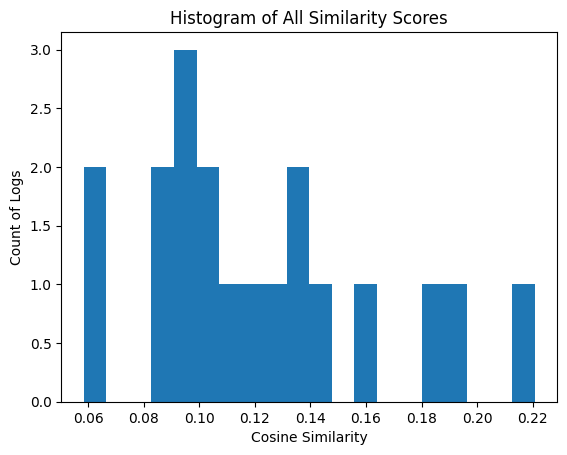

In [ ]:
plt.figure()
plt.hist(scores, bins=20)
plt.xlabel("Cosine Similarity")
plt.ylabel("Count of Logs")
plt.title("Histogram of All Similarity Scores")
plt.show()

This plot shows the falloff in similarity scores related to the prompt

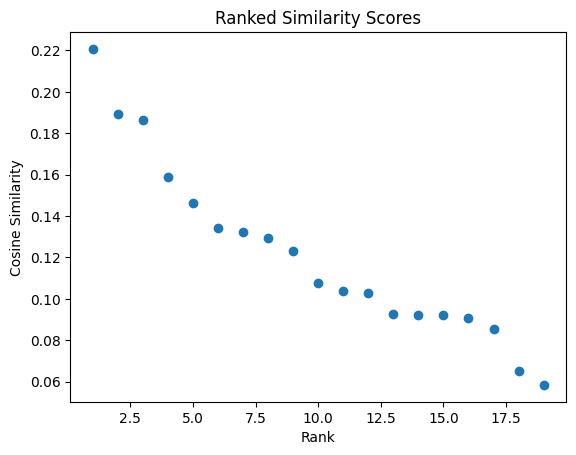

In [ ]:
ranks = np.arange(1, len(scores)+1)
sorted_scores = np.sort(scores)[::-1]
plt.figure()
plt.scatter(ranks, sorted_scores)
plt.xlabel("Rank")
plt.ylabel("Cosine Similarity")
plt.title("Ranked Similarity Scores")
plt.show()